# Introduction:
    Dans un objectif de détection d'anomalie au sein d'un dataset eval.csv à partir d'un dataset pure good.csv, ce notebook propose un ensemble de solutions à cette problématique suivant une démarche scientifique qui vise à analyser, appréhender, décomposer et appliquer différents modèles sur les données de l'Input. Finalement, il sera question d'analyser les résultats, les valider et les synthétiser. 

    Ce notebook est décomposé en plusieurs parties:
    1. Data importation & pre-processing
    2. Data visualisation and comprehension
    3. Data Analysis
    4. Feature Engineering
    5. Models fitting & Performance Analysis:
        a. Isolation Forest
        b. DBSCAN
        c. k-Means
        d. Local Outlier Factor
        e. Elliptic Envellop
        f. SVM
        g. k-NN
        h. LMT
        i. Manually
    6. Final Verdict 
    
Bonne lecture!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest

# Data importation & pre-processing

In [2]:
# data importation
df_raw_good = pd.read_csv('good.csv')
df_raw_eval = pd.read_csv('eval.csv')

In [3]:
# date data type correction 
df_raw_good['date'] = pd.to_datetime(df_raw_good['date'])
df_raw_eval['date'] = pd.to_datetime(df_raw_eval['date'])

In [4]:
# id assignement
df_raw_good.set_index('id', inplace=True)
df_raw_eval.set_index('id', inplace=True)

#### Dans un premier temps, il est intéressant de regrouper les données pour une première analyse:

In [5]:
# regroupement des données 
df_raw = df_raw_good.append(df_raw_eval)

In [6]:
df_raw.info()
#  surface 1 features contains little infos
# surface 2 is not full => data filling
# same for surface_terrain & nature_culture

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2019 entries, 1 to 2019
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2019 non-null   datetime64[ns]
 1   prix             2019 non-null   float64       
 2   ville            2019 non-null   object        
 3   nombre_lots      2019 non-null   int64         
 4   lot1_surface1    1033 non-null   float64       
 5   lot2_surface1    262 non-null    float64       
 6   lot3_surface1    34 non-null     float64       
 7   lot4_surface1    10 non-null     float64       
 8   lot5_surface1    3 non-null      float64       
 9   type             2019 non-null   object        
 10  surface2         1688 non-null   float64       
 11  nombre_pieces    2019 non-null   float64       
 12  nature_culture   310 non-null    object        
 13  surface_terrain  310 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(

# Data visualisation and comprehension: 

In [7]:
len(df_raw.loc[df_raw.prix <= 0]) # tous les prix sont positifs

0

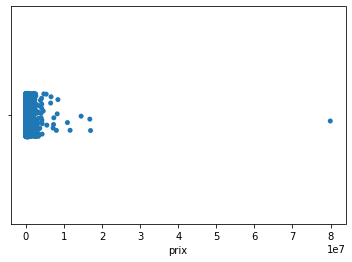

In [8]:
sns.stripplot(data = df_raw, x = 'prix') #un outlier est remarquable sur le plot, mais est-il vraiment un outlier?

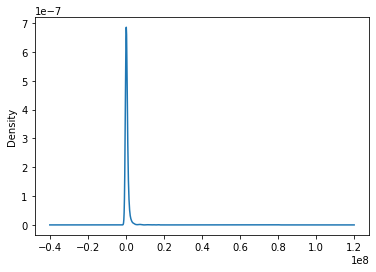

In [9]:
df_raw.prix.plot.density() #bien regroupé

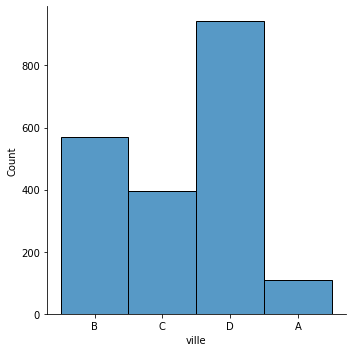

In [10]:
sns.displot(data = df_raw, x = 'ville') # répartition des villes 

In [11]:
df_raw.nombre_lots.value_counts() # répartition de nombres de lots 

1     924
2     641
0     312
3      92
4      31
5       9
6       5
7       1
8       1
16      1
18      1
21      1
Name: nombre_lots, dtype: int64

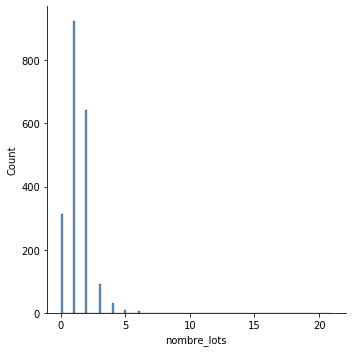

In [12]:
sns.displot(data = df_raw, x = 'nombre_lots')

In [13]:
# analyse des features surface1
df_lot_surface = df_raw[list('lot'+str(i)+'_surface1' for i in range(1,6))] 

In [14]:
df_lot_surface.isna().sum() # number of NaN in each column

lot1_surface1     986
lot2_surface1    1757
lot3_surface1    1985
lot4_surface1    2009
lot5_surface1    2016
dtype: int64

In [15]:
df_lot_surface.isna().sum()*100/len(df_lot_surface) #percentage of NaN in each column

lot1_surface1    48.836057
lot2_surface1    87.023279
lot3_surface1    98.315998
lot4_surface1    99.504705
lot5_surface1    99.851412
dtype: float64

In [16]:
df_lot_surface = df_lot_surface.fillna(0) # NaN means that the "lot" doesn"t exist so it's surface == 0 (for a first analysis)

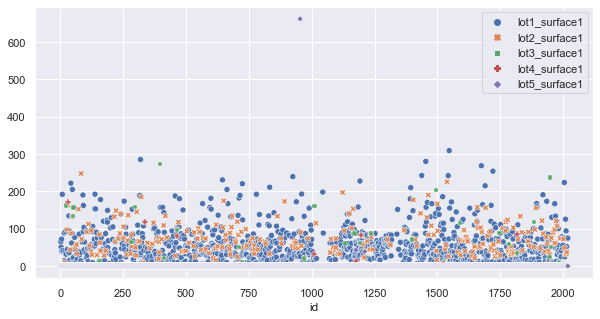

In [17]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = df_lot_surface)
# répartition des surfaces 1 

In [18]:
df_lot_surface.sum(axis=1) #total surface 1 = sum of surfaces 1

id
1        0.00
2       65.09
3       50.35
4        0.00
5       71.94
        ...  
2015    36.83
2016     0.00
2017     0.00
2018     0.00
2019    74.60
Length: 2019, dtype: float64

In [19]:
df_raw.type.value_counts()

Appartement                                 1229
Dépendance                                   335
Maison                                       307
Local industriel. commercial ou assimilé     148
Name: type, dtype: int64

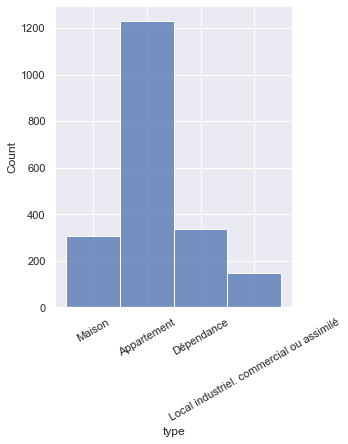

In [20]:
fig_type = sns.displot(data= df_raw, x = 'type')
fig_type.set_xticklabels(rotation=30)
#repartition of estate types

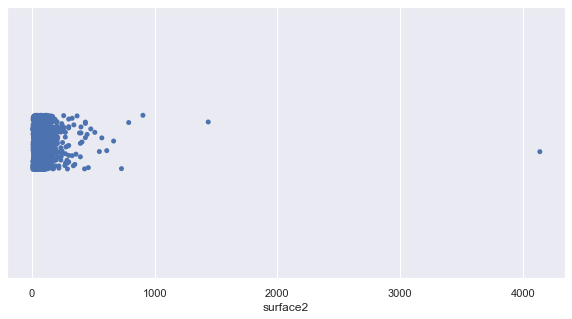

In [21]:
sns.stripplot(data = df_raw, x = 'surface2') 
# un outlier semble se distinguer, serait-t-il le même que celui du prix? 

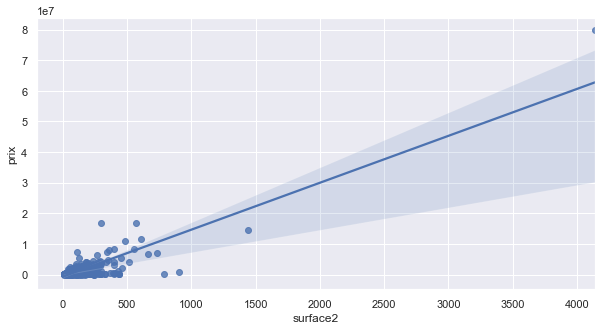

In [22]:
sns.regplot(data = df_raw, x = 'surface2', y = 'prix')
#l'outlier du prix et le même que celui de la surface. Vu que les deux features sont correllées et que l'outlier est dans 
#cette zone de régression, ce dernier n'est finalement pas une anomalie

In [23]:
df_raw.prix.corr(df_raw.surface2)
#correlation élevée entre le prix et la surface du bien, ce qui est cohérent avec les règles du marché immobilier

0.8750394777099838

In [24]:
df_raw.nombre_pieces.value_counts()
# nombre de pièces varie entre 0 et 16

0.0     487
2.0     376
3.0     313
1.0     311
4.0     250
5.0     158
6.0      71
7.0      24
9.0       7
10.0      7
8.0       7
11.0      3
16.0      2
12.0      2
14.0      1
Name: nombre_pieces, dtype: int64

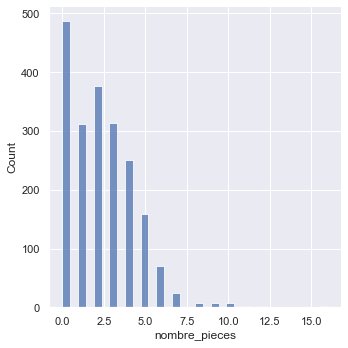

In [25]:
fig_type = sns.displot(data= df_raw, x = 'nombre_pieces')
# repartition de nombre de pièces

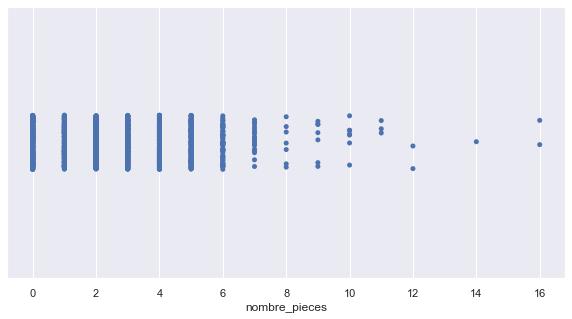

In [26]:
sns.stripplot(data = df_raw, x = 'nombre_pieces') 
#quelques outliers mais rien de concluant

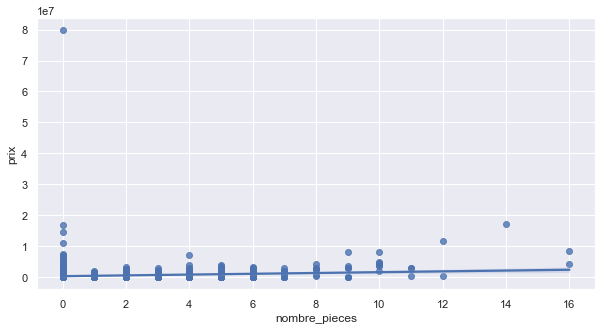

In [27]:
sns.regplot(data = df_raw, x = 'nombre_pieces', y = 'prix')
# regression positive du prix en fonction du nombre de pièces => cohérent avec les règles du marché 

In [28]:
df_raw.nature_culture.value_counts()
# peu de données 

sols    310
Name: nature_culture, dtype: int64

In [29]:
df_raw.nature_culture.isna().sum()*100/len(df_raw) 
#percentage de valeurs manquantes: 84%

84.6458642892521

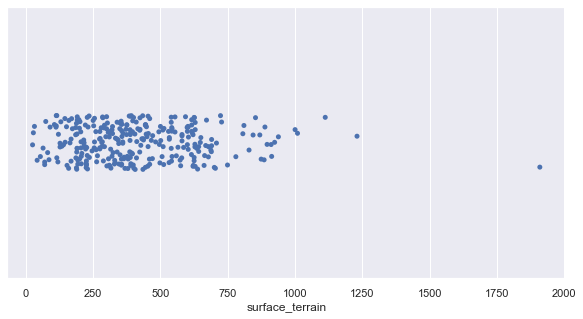

In [30]:
sns.stripplot(data = df_raw, x = 'surface_terrain') 
# quelques outliers mais rien de concluant

In [31]:
df_raw.surface_terrain.isna().sum()*100/ len(df_raw) 
#percentage de valeurs manquantes: 84%

84.6458642892521

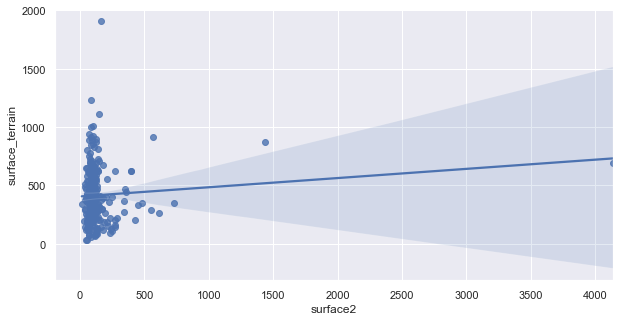

In [32]:
sns.regplot(data = df_raw, x = 'surface2', y = 'surface_terrain')
# analyse de la relation surface2 et surface_terrain, rien de concluant 

# Data Analysis:

#### Une première analyse des features peut suggérer une première approche:
        En immobilier, la valeur d'un bien dépends de son type, sa ville et sa superficie. 
        Ces paramètres peuvent être un vecteur d'analyse. 
        L'idée ici est de comparer df_raw_eval et df_raw good sur ces features.

In [33]:
df_raw_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 1 to 1019
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1019 non-null   datetime64[ns]
 1   prix             1019 non-null   float64       
 2   ville            1019 non-null   object        
 3   nombre_lots      1019 non-null   int64         
 4   lot1_surface1    523 non-null    float64       
 5   lot2_surface1    133 non-null    float64       
 6   lot3_surface1    14 non-null     float64       
 7   lot4_surface1    4 non-null      float64       
 8   lot5_surface1    1 non-null      float64       
 9   type             1019 non-null   object        
 10  surface2         860 non-null    float64       
 11  nombre_pieces    1019 non-null   float64       
 12  nature_culture   170 non-null    object        
 13  surface_terrain  170 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(

In [34]:
df_raw_eval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1020 to 2019
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1000 non-null   datetime64[ns]
 1   prix             1000 non-null   float64       
 2   ville            1000 non-null   object        
 3   nombre_lots      1000 non-null   int64         
 4   lot1_surface1    510 non-null    float64       
 5   lot2_surface1    129 non-null    float64       
 6   lot3_surface1    20 non-null     float64       
 7   lot4_surface1    6 non-null      float64       
 8   lot5_surface1    2 non-null      float64       
 9   type             1000 non-null   object        
 10  surface2         828 non-null    float64       
 11  nombre_pieces    1000 non-null   float64       
 12  nature_culture   140 non-null    object        
 13  surface_terrain  140 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int

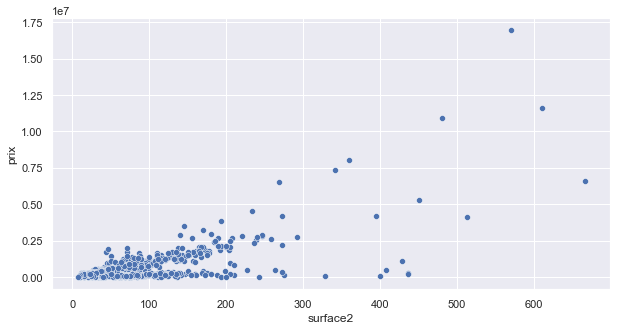

In [35]:
sns.scatterplot(data = df_raw_good, x = 'surface2', y = 'prix')
#on remarque clairement des tendances linéaires mais un peu bruitées 

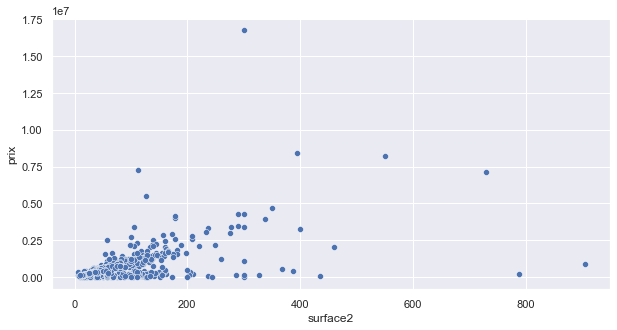

In [36]:
sns.scatterplot(data = df_raw_eval.loc[df_raw_eval.surface2 < 1000], x = 'surface2', y = 'prix')
# même remarque avec quelques outliers remarquables 

##### Les deux prochaines cellules représentent une grille de graphe 'prix en fonction de surface2'.
##### Chaque ligne de la grille représente un type de bien. 
##### Chauque colonne de la grille représente une ville

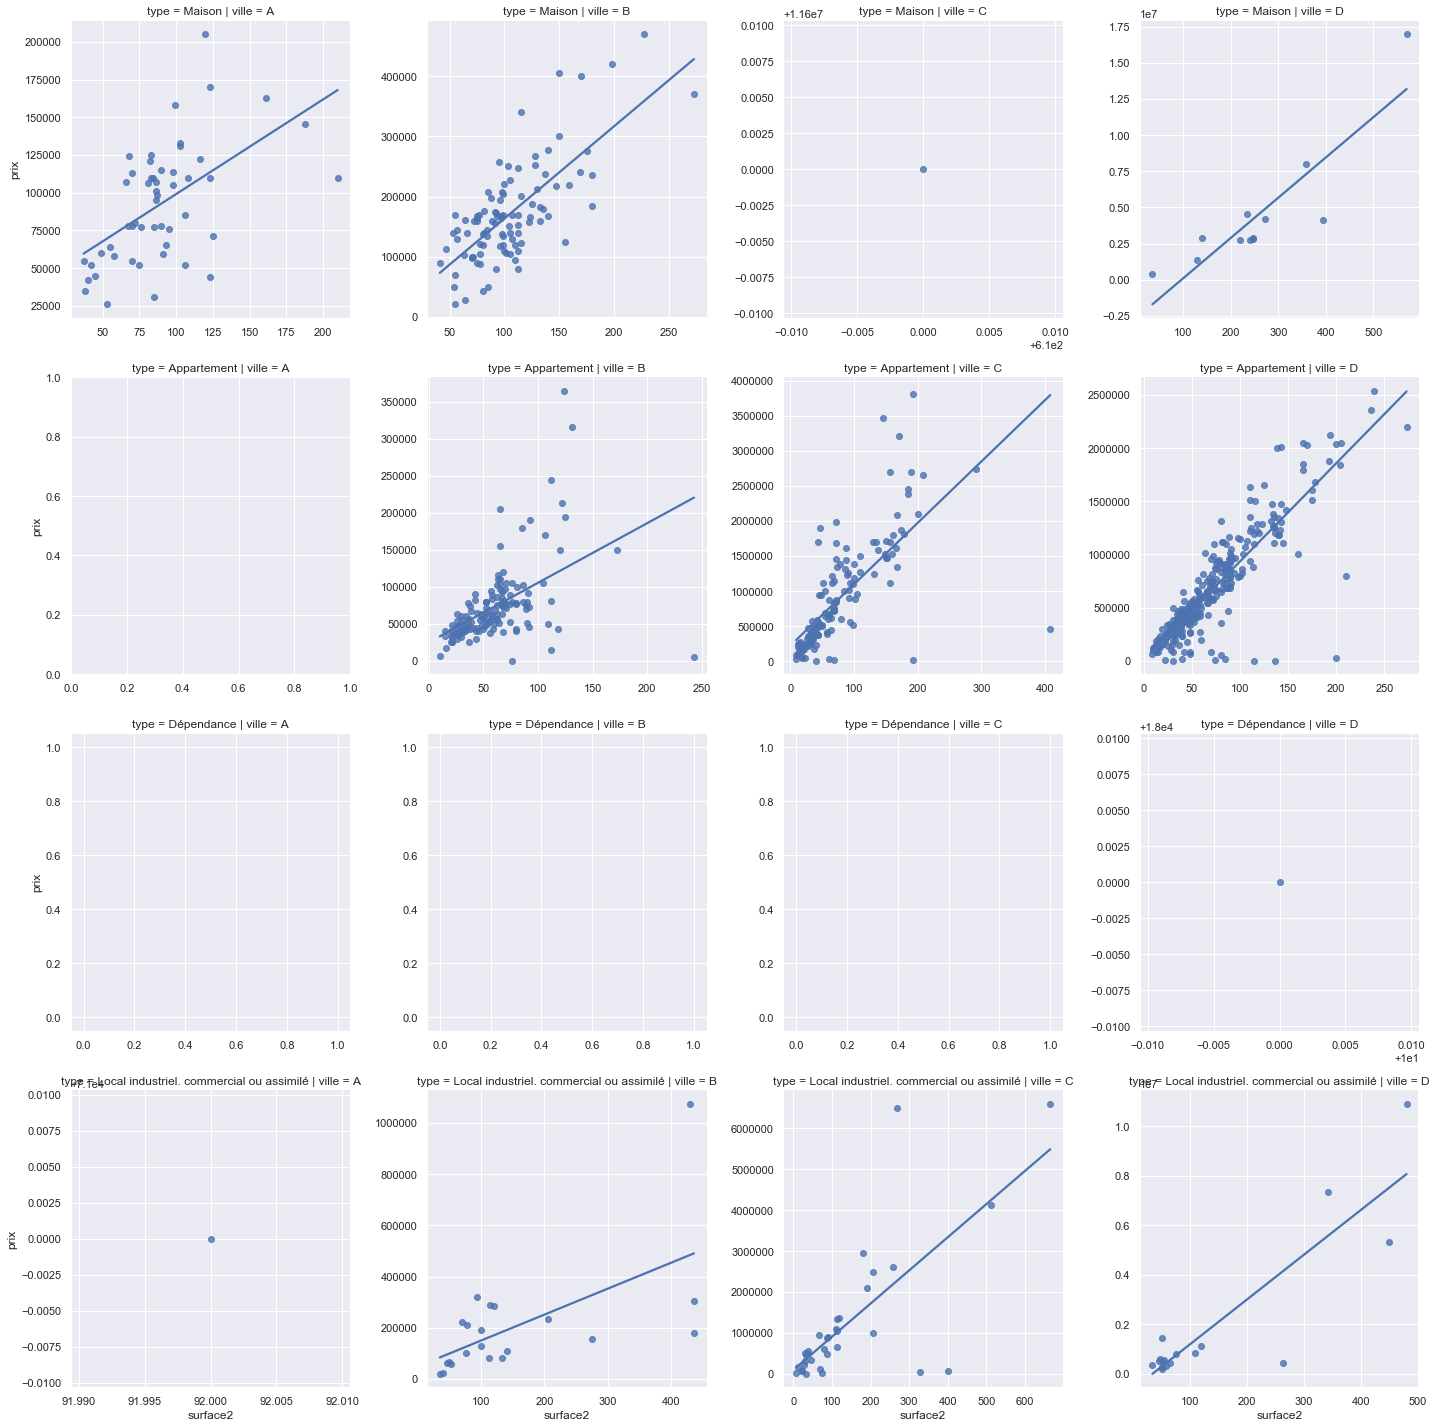

In [37]:
g = sns.FacetGrid(df_raw_good, row ='type', col="ville", col_order=['A','B','C','D'],
                  sharex=False, sharey=False, height=5, aspect=1)
g.map(sns.regplot, "surface2", "prix", ci= 0)
g.add_legend()
# les points isolés sont fausement représentés!!!
# cette répartition nous permets de voir plus claire 
# la majorité des regression sont bien justifiés

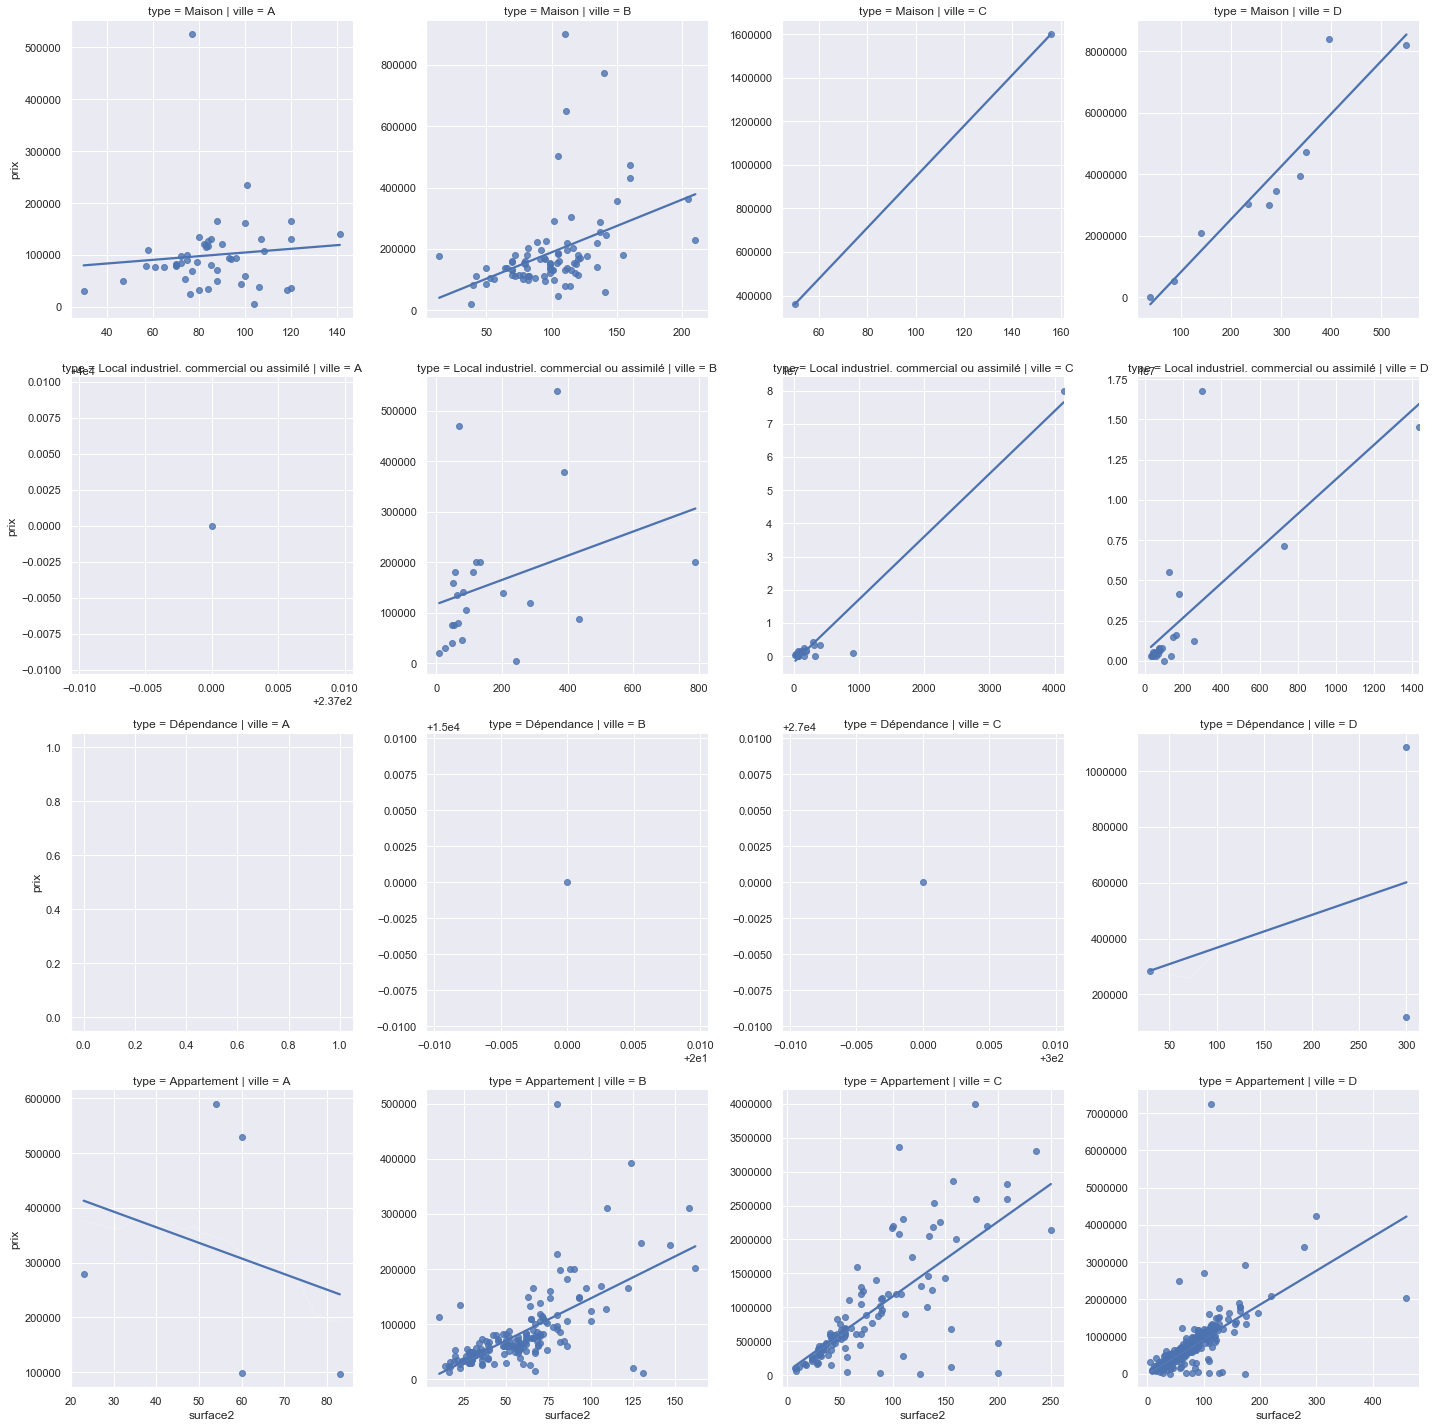

In [38]:
g = sns.FacetGrid(df_raw_eval, row ='type',col="ville", col_order=['A','B','C','D'],
                  sharex=False, sharey=False, height=5, aspect=1)
g.map(sns.regplot, "surface2", "prix", ci= 0)
g.add_legend()
# les regressions sont moins prononcés
# on remarque la présence d'instance dans des catégories vides pour "good"

# Feature Engineering: 

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 

In [40]:
# les surfaces 2 sont dropées car peu d'informations 
df_good = df_raw_good.drop(list('lot'+str(i)+'_surface1' for i in range(1,6)), axis = 1)

# la date est encodée en timestamp
df_good.date = pd.to_datetime(df_good.date, unit='D')

df_good['date_num'] = df_good.date.astype('int64') // 10**9

df_good_num = df_good.drop('date',axis=1)

# les surfaces terrains vides sont présumés pour les appartments et autres cas particulier, ainsi leur valeur est égale à 0
df_good_num.surface_terrain.fillna(0, inplace= True)

# le type du terrain est neant car le terrain n'existe pas pour les cas cités précédement
df_good_num.nature_culture.fillna('Neant', inplace = True )

#L'encoding utilisé est le One-hot Encoding

df_good_enc = pd.get_dummies(df_good_num)

# les données sont standardizés afin de faire une regression pour estimer la surface2 des cases vides 
list_num_features = ['prix','nombre_lots', 'nombre_pieces', 'surface_terrain', 'date_num']

scaler = StandardScaler()
df_good_scaled = pd.DataFrame(scaler.fit_transform(df_good_enc[list_num_features]), columns= list_num_features, index = df_good_enc.index)

df_good_reg = df_good_enc
df_good_reg[list_num_features] = df_good_scaled

#données de régression
X_good_predict = df_good_reg.loc[df_good_reg.surface2.isna()].drop('surface2', axis = 1)

X_good_train = df_good_reg.loc[~df_good_reg.surface2.isna()].drop('surface2', axis = 1)

y_good_train = df_good_reg.loc[~df_good_reg.surface2.isna()]['surface2']

#fit de la régression linéaire
LR = LinearRegression().fit(X_good_train, y_good_train)


y_good_pred = pd.Series(LR.predict(X_good_predict), index= X_good_predict.index)

y_good_final = y_good_pred.append(y_good_train).sort_index()

df_good_full = df_good_reg.copy()
df_good_full['surface2'] = y_good_final

df_good_full[list_num_features] = df_good_num[list_num_features]

# Calcule d'une nouvelle feature plus intéressante que la surface du terrain : la surface non habitées 

df_good_full['surface_extra'] = df_good_full.surface_terrain - df_good_full.surface2

df_good_full['surface_extra'] = df_good_full['surface_extra'].apply(lambda x : max(0,x) ) 
# si négative, l'erreur vient de la regression

df_good_full = df_good_full.drop(['surface_terrain'], axis=1)

In [41]:
# même pipeline pour les données d'eval
df_eval = df_raw_eval.drop(list('lot'+str(i)+'_surface1' for i in range(1,6)), axis = 1)

df_eval.date = pd.to_datetime(df_eval.date, unit='D')

df_eval['date_num'] = df_eval.date.astype('int64') // 10**9

df_eval_num = df_eval.drop('date',axis=1)

df_eval_num.surface_terrain.fillna(0, inplace= True)

df_eval_num.nature_culture.fillna('Neant', inplace = True )

df_eval_enc = pd.get_dummies(df_eval_num)


list_num_features = ['prix','nombre_lots', 'nombre_pieces', 'surface_terrain', 'date_num']

scaler_eval = StandardScaler()
df_eval_scaled = pd.DataFrame(scaler_eval.fit_transform(df_eval_enc[list_num_features]), 
                              columns= list_num_features, index = df_eval_enc.index)

df_eval_reg = df_eval_enc
df_eval_reg[list_num_features] = df_eval_scaled

X_predict = df_eval_reg.loc[df_eval_reg.surface2.isna()].drop('surface2', axis = 1)

X_train = df_eval_reg.loc[~df_eval_reg.surface2.isna()].drop('surface2', axis = 1)

y_train = df_eval_reg.loc[~df_eval_reg.surface2.isna()]['surface2']


LR = LinearRegression().fit(X_train, y_train)


y_pred = pd.Series(LR.predict(X_predict), index= X_predict.index)

y_final = y_pred.append(y_train).sort_index()

df_eval_full = df_eval_reg.copy()
df_eval_full['surface2'] = y_final

df_eval_full[list_num_features] = df_eval_num[list_num_features]

df_eval_full['surface_extra'] = df_eval_full.surface_terrain - df_eval_full.surface2

df_eval_full['surface_extra'] = df_eval_full['surface_extra'].apply(lambda x : max(0,x) )

df_eval_full = df_eval_full.drop(['surface_terrain'], axis=1)


# Modèles:

#### Différents modèles sont utilisés dans ce qui suit. Toutefois, la même méthodolgie est utilisée:
    1. Création de l'instance de modèle
    2. Fit de l'instance
    3. Prediction des anomalies 
    4. Plot des anomalies 
    5. Analyse des résultats
    6. Création d'un set des indices des anomalies 

# Isolation Forest

In [42]:
X_eval = df_eval_full.copy()

clf = IsolationForest(behaviour='new', max_samples=100, contamination=0.05)

clf.fit(df_good_full)

pred_test = clf.predict(X_eval)

In [43]:
X_eval['tag'] = pd.Series(pred_test, index=X_eval.index)

In [44]:
X_eval['tag'].value_counts()

 1    954
-1     46
Name: tag, dtype: int64

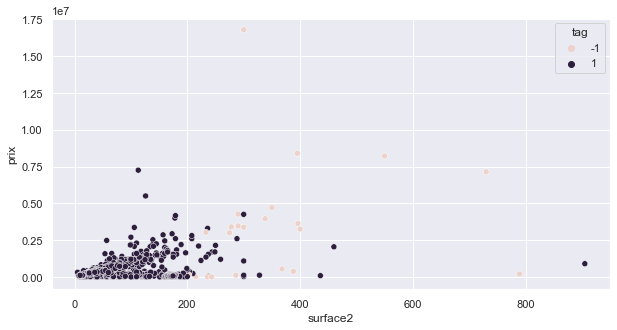

In [45]:
sns.scatterplot(data=X_eval.loc[X_eval.surface2<1000], x = 'surface2', y= 'prix', hue= 'tag')
# Les anomalies sont détectées comme étant les plus isolés, ceci n'est pas forcément pertinent car regression 

In [46]:
set_isoforest = set(X_eval.loc[X_eval.tag == -1].index)

# DBSCAN

In [47]:
# une étape de standarization est nécessaire pour cet algo

In [48]:
from sklearn.cluster import DBSCAN 

In [49]:
list_dbscan_features = ['prix','nombre_lots', 'nombre_pieces', 'surface2', 'date_num', 'surface_extra']
list_dbscan_features_enc = ['ville_A', 'ville_B', 'ville_C', 'ville_D', 'type_Appartement',
       'type_Dépendance', 'type_Local industriel. commercial ou assimilé',
       'type_Maison', 'nature_culture_Neant', 'nature_culture_sols']

In [50]:
scaler_good_dbscan = StandardScaler()
df_good_scaled_dbscan = pd.DataFrame(scaler_good_dbscan.fit_transform(df_good_full[list_dbscan_features]), 
                              columns= list_dbscan_features, index = df_good_full.index)

In [51]:
df_good_scaled_dbscan[list_dbscan_features_enc] = df_good_full[list_dbscan_features_enc]

In [52]:
scaler_eval_dbscan = StandardScaler()
df_eval_scaled_dbscan = pd.DataFrame(scaler_eval_dbscan.fit_transform(df_eval_full[list_dbscan_features]), 
                              columns= list_dbscan_features, index = df_eval_full.index)

In [53]:
df_eval_scaled_dbscan[list_dbscan_features_enc] = df_eval_full[list_dbscan_features_enc]

In [54]:
dbscan = DBSCAN(eps=1.5, min_samples=3, metric='l2')
dbscan_labels = dbscan.fit_predict(df_eval_scaled_dbscan)
dbscan_pred = pd.Series(dbscan_labels, index= df_eval_scaled_dbscan.index)
dbscan_anomalies = df_eval_scaled_dbscan[dbscan_pred==-1]

In [55]:
set_dbscan = set(dbscan_anomalies.index)

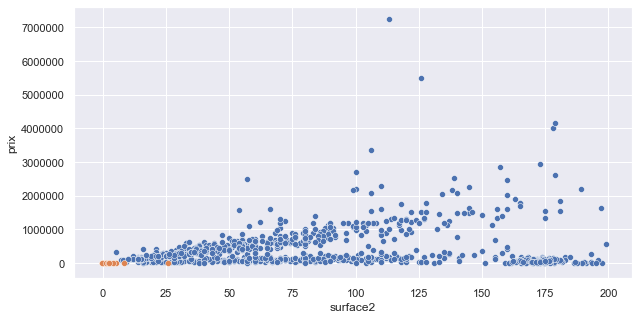

In [56]:
sns.scatterplot(data = df_eval_full.loc[df_eval_full.surface2 < 200], x = 'surface2', y = 'prix')
sns.scatterplot(data = dbscan_anomalies.loc[dbscan_anomalies.surface2 < 200], x = 'surface2', y = 'prix')
#les anomalies ont l'air d'être les proches de (0,0) avec une tendance vers les prix pas chers. 
# Ceci semble être une detection intéressante!
# Cepandant les outliers les plus claires ne sont pas détectés 

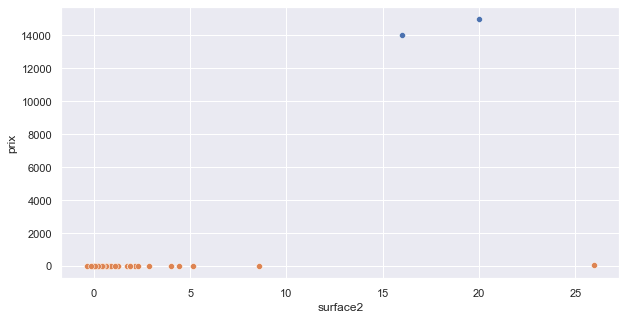

In [57]:
sns.scatterplot(data = df_eval_full.loc[(df_eval_full.surface2 < 30) & (df_eval_full.prix <20000)], x = 'surface2', y = 'prix')
sns.scatterplot(data = dbscan_anomalies.loc[(dbscan_anomalies.surface2 < 30) & (dbscan_anomalies.prix <20000)], x = 'surface2', y = 'prix')

# k-Means : 

In [58]:
from sklearn.cluster import KMeans

In [59]:
kmeans_labels =KMeans(n_clusters=2, random_state=0).fit(df_good_scaled_dbscan).predict(df_eval_scaled_dbscan)
kmeans_pred = pd.Series(kmeans_labels, index= df_eval_scaled_dbscan.index)
kmeans_anomalies = df_eval_full[kmeans_pred==0]

In [60]:
set_kmeans = set(kmeans_anomalies.index)

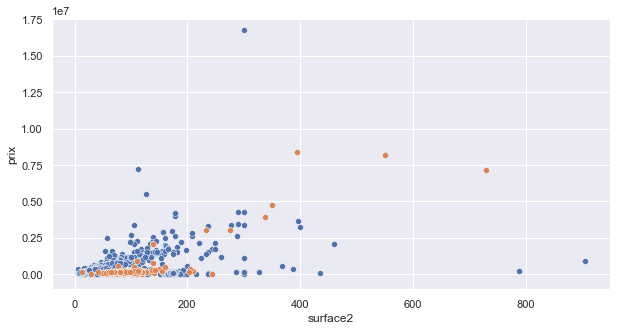

In [61]:
sns.scatterplot(data = df_eval_full.loc[df_eval_full.surface2 < 1000], x = 'surface2', y = 'prix')
sns.scatterplot(data = kmeans_anomalies.loc[kmeans_anomalies.surface2 < 1000], x = 'surface2', y = 'prix')
# La detection s'est faite suivant un axe de regression (presque horizontale) avec quelques points isolés 
#qui semblent être des outliers
# Cette méthode semble être peu efficaces car peut de vrais outliers detectés

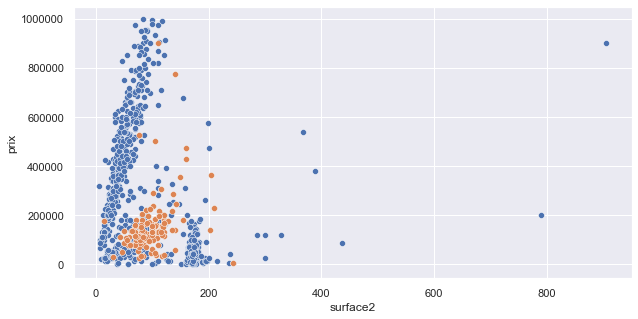

In [62]:
sns.scatterplot(data = df_eval_full.loc[(df_eval_full.surface2 < 1000) & (df_eval_full.prix <1e6)], x = 'surface2', y = 'prix')
sns.scatterplot(data = kmeans_anomalies.loc[(kmeans_anomalies.surface2 < 1000) & (kmeans_anomalies.prix <1e6)], x = 'surface2', y = 'prix')

# Local Outlier Factor: 

In [63]:
from sklearn.neighbors import LocalOutlierFactor

In [64]:
clf_lof = LocalOutlierFactor(n_neighbors=5, contamination=.05)
y_pred = clf_lof.fit_predict(df_eval_full)
LOF_Scores = clf_lof.negative_outlier_factor_
LOF_pred = pd.Series(y_pred, index= df_eval_full.index).replace([-1,1],[1,0])
LOF_anomalies = df_eval_full[LOF_pred==1]

In [65]:
set_LOF = set(LOF_anomalies.index)

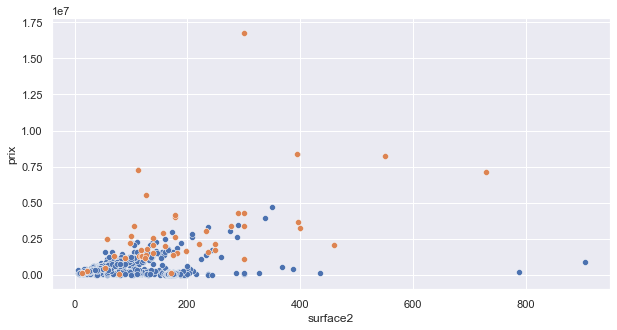

In [66]:
sns.scatterplot(data = df_eval_full.loc[df_eval_full.surface2 < 1000], x = 'surface2', y = 'prix')
sns.scatterplot(data = LOF_anomalies.loc[LOF_anomalies.surface2 < 1000], x = 'surface2', y = 'prix')
# Cette méthode detecte efficacment les outliers qui sort de la regression que ça soit dans la nuage de points 
#ou dehors 

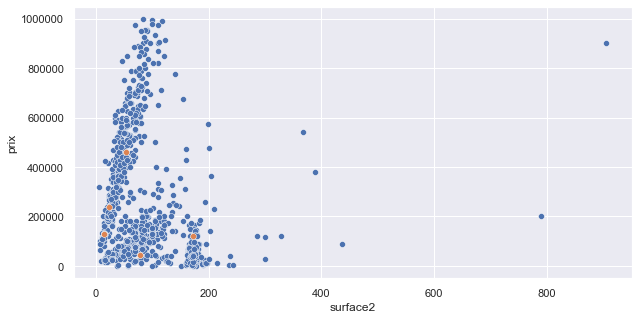

In [67]:
sns.scatterplot(data = df_eval_full.loc[(df_eval_full.surface2 < 1000) & (df_eval_full.prix <1e6)], x = 'surface2', y = 'prix')
sns.scatterplot(data = LOF_anomalies.loc[(LOF_anomalies.surface2 < 1000) & (LOF_anomalies.prix <1e6)], x = 'surface2', y = 'prix')


# Elliptic Envellop: 

In [68]:
from sklearn.covariance import EllipticEnvelope

In [69]:
clf_ee = EllipticEnvelope(contamination=.05,random_state=0)
clf_ee.fit(df_eval_full)
ee_scores = pd.Series(clf_ee.decision_function(df_eval_full)) 
ee_predict = clf_ee.predict(df_eval_full)
ee_anomalies = df_eval_full[ee_predict==-1]

C:\Users\pc\Anaconda\lib\site-packages\sklearn\covariance\robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\pc\Anaconda\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-64.808764644632546 > -84.852929447874018). You may want to try with a higher value of support_fraction (current value: 0.511).
  RuntimeWarning)
C:\Users\pc\Anaconda\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-69.872155895616828 > -70.119993644958697). You may want to try with a higher value of support_fraction (current value: 0.511).
  RuntimeWarning)
C:\Users\pc\Anaconda\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has

In [70]:
set_ee = set(ee_anomalies.index)

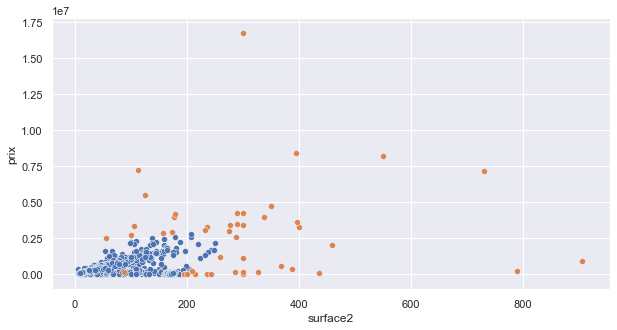

In [71]:
sns.scatterplot(data = df_eval_full.loc[df_eval_full.surface2 < 1000], x = 'surface2', y = 'prix')
sns.scatterplot(data = ee_anomalies.loc[ee_anomalies.surface2 < 1000], x = 'surface2', y = 'prix')
#Cette méthode detecte des outliers qui sortent du nuage de données.

# SVM One-class: 

In [72]:
from sklearn import svm

In [73]:
clf_svm = svm.OneClassSVM(nu=.05, kernel='linear')
clf_svm.fit(df_eval_full)
svm_pred=clf_svm.predict(df_eval_full)
svm_anomalies = df_eval_full[svm_pred==-1]

In [74]:
set_svm = set(svm_anomalies.index)

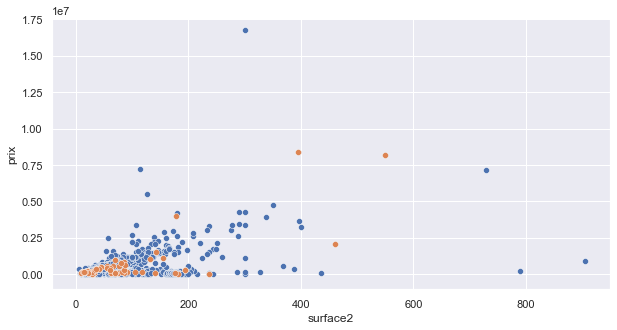

In [75]:
sns.scatterplot(data = df_eval_full.loc[df_eval_full.surface2 < 1000], x = 'surface2', y = 'prix')
sns.scatterplot(data = svm_anomalies.loc[svm_anomalies.surface2 < 1000], x = 'surface2', y = 'prix')
#Puisque le kernel choisi est linéaire, le choix des outliers est plus influencés par d'autres features.

sns.scatterplot(data = df_eval_full.loc[(df_eval_full.surface2 < 1000) & (df_eval_full.prix <1e6)], x = 'surface2', y = 'prix')
sns.scatterplot(data = svm_anomalies.loc[(svm_anomalies.surface2 < 1000) & (svm_anomalies.prix <1e6)], x = 'surface2', y = 'prix')


# K-NN

In [77]:
from sklearn.neighbors import NearestNeighbors

In [78]:
knn = NearestNeighbors(n_neighbors=3)
knn.fit(df_eval_full)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [79]:
distances, indexes = knn.kneighbors(df_eval_full)

In [80]:
q95_knn = np.quantile(distances.mean(axis =1), 0.95)

In [81]:
outlier_index = np.where(distances.mean(axis = 1) > q95_knn)
outlier_index

(array([200, 349, 350, 359, 369, 372, 374, 418, 419, 431, 434, 440, 471,
        475, 484, 497, 501, 504, 507, 522, 523, 527, 578, 610, 611, 634,
        649, 653, 664, 665, 670, 694, 701, 708, 731, 732, 748, 750, 774,
        808, 865, 876, 900, 911, 915, 929, 930, 985, 991, 997], dtype=int64),)

In [82]:
set_knn = set(outlier_index[0])

In [83]:
outlier_values = df_eval_full.iloc[outlier_index]

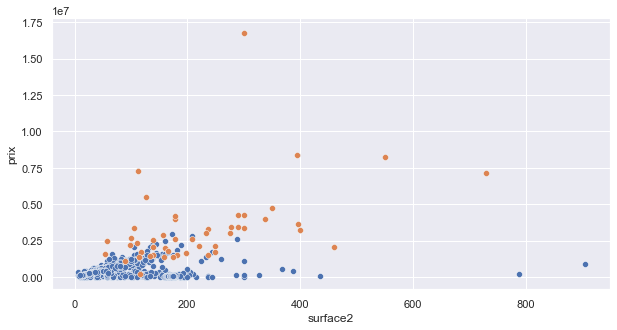

In [84]:
sns.scatterplot(data=df_eval_full.loc[df_eval_full.surface2<1000], x= 'surface2', y='prix')
sns.scatterplot(data=outlier_values.loc[outlier_values.surface2<1000], x= 'surface2', y='prix')
# les outliers sont détectés comme ceux qui ont le moins de voisins
#Ce qui est pas forcément cohérents

# Linear Model Tree: 

Une idée qui serait regrétable si non exploitée est de classer les points par type et ville et fitter une regression du prix en fonction des autres features sur les données good. 
Cette regression sera utilisée pour prédire le prix de l'eval. Une erreur sera calculée comme la différence entre la prédiction et le prix réel. A partir de cette dernière, on pourra choisir les outliers comme étant les points avec un maximum d'erreur. Dans notre cas, ceci consernera les points qui sont dans le top 1% de leurs catégories.

In [85]:
df_eval_num.surface2 = y_final
df_good_num.surface2 = y_good_final

df_good_num['surface_extra'] = df_good_num.surface_terrain - df_good_num.surface2
df_good_num['surface_extra'] = df_good_num['surface_extra'].apply(lambda x : max(0,x) )
df_good_num = df_good_num.drop(['surface_terrain'], axis=1)

df_eval_num['surface_extra'] = df_eval_num.surface_terrain - df_eval_num.surface2
df_eval_num['surface_extra'] = df_eval_num['surface_extra'].apply(lambda x : max(0,x) )
df_eval_num = df_eval_num.drop(['surface_terrain'], axis=1)

In [86]:
list_lmt_scaled_features = ['nombre_lots','surface2','nombre_pieces','surface_extra','date_num']

In [87]:
df_good_lmt = pd.DataFrame(scaler.fit_transform(df_good_num[list_lmt_scaled_features]), 
                              columns= list_lmt_scaled_features, index = df_good_num.index)
df_good_lmt[['ville','type','prix']] = df_good_num[['ville','type','prix']]

df_eval_lmt = pd.DataFrame(scaler.fit_transform(df_eval_num[list_lmt_scaled_features]), 
                              columns= list_lmt_scaled_features, index = df_eval_num.index)
df_eval_lmt[['ville','type','prix']] = df_eval_num[['ville','type','prix']]

In [88]:
dict_error_lmt = dict()
for ville in df_eval_lmt.ville.unique():
    
    df_good_ville = df_good_lmt.loc[df_good_lmt.ville == ville]
    df_eval_ville = df_eval_lmt.loc[df_eval_lmt.ville == ville]
                                         
    for type_bien in df_eval_lmt.type.unique():
    
        df_good_ville_type = df_good_ville.loc[df_good_ville.type == type_bien]
        df_eval_ville_type = df_eval_ville.loc[df_eval_ville.type == type_bien]

        X_lmt_train = df_good_ville_type.drop(['prix','ville','type'], axis=1)
        y_lmt_train = df_good_ville_type.prix

        X_lmt_eval = df_eval_ville_type.drop(['prix','ville','type'], axis=1)
        y_lmt_eval = df_eval_full.prix
        
        if (len(X_lmt_eval) > 0) & (len(X_lmt_train) > 4): 
            LR_lmt = LinearRegression().fit(X_lmt_train, y_lmt_train)

            y_lmt_pred = pd.Series(LR_lmt.predict(X_lmt_eval), index= X_lmt_eval.index)

            error_lmt = abs(y_lmt_eval - y_lmt_pred)
            
            dict_error_lmt[str(ville)+' - ' + str(type_bien)] = error_lmt

In [89]:
df_error_lmt = pd.DataFrame.from_dict(dict_error_lmt)
df_error_lmt['prix'] = df_eval_lmt['prix']
df_error_lmt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1020 to 2019
Data columns (total 13 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   A - Maison                                    48 non-null     float64
 1   B - Maison                                    85 non-null     float64
 2   B - Local industriel. commercial ou assimilé  24 non-null     float64
 3   B - Dépendance                                15 non-null     float64
 4   B - Appartement                               167 non-null    float64
 5   C - Local industriel. commercial ou assimilé  25 non-null     float64
 6   C - Dépendance                                41 non-null     float64
 7   C - Appartement                               118 non-null    float64
 8   D - Maison                                    10 non-null     float64
 9   D - Local industriel. commercial ou assimilé  24 non-null   

In [90]:
list_cases = list(df_error_lmt.columns)[:-1] #del prix

In [91]:
list_index_outliers = list()
for case in list_cases:
    df_error_knn_case = df_error_lmt[[case,'prix']].dropna()

    knn_lmt = NearestNeighbors(n_neighbors=3)
    knn_lmt.fit(df_error_knn_case)

    distances_lmt_knn, indexes_lmt_knn = knn_lmt.kneighbors(df_error_knn_case)

    df_knn_distance = pd.DataFrame(distances_lmt_knn, index= df_error_knn_case.index)

    series_knn_distance = df_knn_distance.mean(axis=1)

    qant = series_knn_distance.quantile(0.99)

    outlier_index_lmt = series_knn_distance.loc[lambda x: x> qant]
    
    list_index_outliers += list(outlier_index_lmt.index)

In [92]:
set_lmt = set(list_index_outliers)

In [93]:
set_inliers = set(df_error_lmt.index) - set(list_index_outliers)

In [94]:
dict_outliers = {}
for e in list_index_outliers:
    dict_outliers[e] = [True]

for e in set_inliers:
    dict_outliers[e] = [False]

In [95]:
df_anomaly_lmt = pd.DataFrame.from_dict(dict_outliers, orient='index', columns = ['anomaly'])
df_anomaly_lmt.sort_index(inplace=True)

In [96]:
lmt_anomalies = df_eval_full.loc[list_index_outliers]

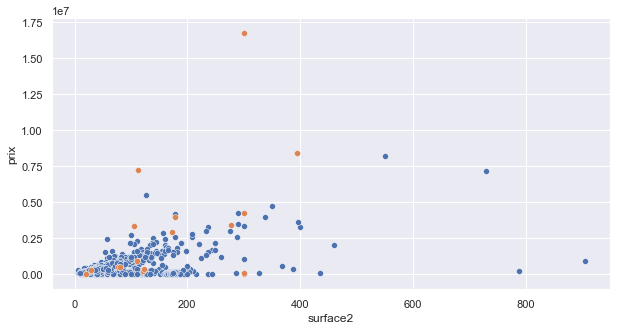

In [97]:
sns.scatterplot(data = df_eval_full.loc[df_eval_full.surface2 < 1000], x = 'surface2', y = 'prix')
sns.scatterplot(data = lmt_anomalies.loc[lmt_anomalies.surface2 < 1000], x = 'surface2', y = 'prix')
#les points detectés sont les plus loins de leur prix prédits. Ainsi, les outliers sont detectés d'une manière plus précise
# La granulité joue un rôle important dans notre cas.

# Manually:

Ici, la detection se fait par ecartement de cas extremes comme les prix presque nulle et les transactions nouvelles dans leur catégorie.


In [98]:
df_manual_anomalies = pd.DataFrame()

In [99]:
df_good_num.loc[df_good_num.prix <= 1000]

,prix,ville,nombre_lots,type,surface2,nombre_pieces,nature_culture,date_num,surface_extra
id,,,,,,,,,
213,150.0,B,2,Appartement,76.000000,3.0,Neant,1486684800,0.0
320,1000.0,C,1,Local industriel. commercial ou assimilé,33.000000,0.0,Neant,1536105600,0.0
469,800.0,D,1,Appartement,136.000000,5.0,Neant,1550016000,0.0
750,1.0,D,1,Dépendance,7.747492,0.0,Neant,1485993600,0.0
836,650.0,D,1,Appartement,115.000000,4.0,Neant,1539216000,0.0
962,1.0,D,1,Appartement,30.000000,2.0,Neant,1494374400,0.0


In [100]:
df_eval_num.loc[(df_eval_num.prix <= 1000) & ~df_eval_num.surface2.isna()]

,prix,ville,nombre_lots,type,surface2,nombre_pieces,nature_culture,date_num,surface_extra
id,,,,,,,,,
1456,1.00,C,1,Local industriel. commercial ou assimilé,151.000000,0.0,Neant,1560988800,0.0
1487,500.00,C,1,Dépendance,176.688685,0.0,Neant,1459382400,0.0
1555,1000.00,D,2,Appartement,173.000000,4.0,Neant,1561680000,0.0
1624,476.02,D,1,Maison,38.000000,2.0,Neant,1436313600,0.0
1781,1000.00,D,1,Local industriel. commercial ou assimilé,100.000000,0.0,Neant,1528761600,0.0


In [101]:
df_manual_anomalies = df_manual_anomalies.append(df_eval_num.loc[(df_eval_num.prix <= 1000) & ~df_eval_num.surface2.isna()])

In [102]:
for ville in df_eval_lmt.ville.unique():
    
    df_good_ville = df_good_num.loc[df_good_num.ville == ville]
    df_eval_ville = df_eval_num.loc[df_eval_num.ville == ville]
                                         
    for type_bien in df_eval_lmt.type.unique():
    
        df_good_ville_type = df_good_ville.loc[df_good_ville.type == type_bien]
        df_eval_ville_type = df_eval_ville.loc[df_eval_ville.type == type_bien]
        
        if (len(df_good_ville_type) == 0) & (len(df_eval_ville_type) !=0): 
            df_manual_anomalies = df_manual_anomalies.append(df_eval_ville_type)

In [103]:
set_manual = set(df_manual_anomalies.index)

In [104]:
set_manual

{1193, 1206, 1456, 1487, 1488, 1536, 1555, 1624, 1781, 1962}

# Final Verdict: 

Le choix se porte sur les deux dernières méthodes car elles sont les plus adaptées à notre cas. De plus, les analyses DBSCAN et Elliptic Envellop semblent données des résultats intéressants. Leur intersection peut être considérer comme assez fiable comme réponse. 

In [105]:
set_deterministic = set_manual.union(set_lmt)

In [106]:
set_ml = set_dbscan.intersection(set_ee)

In [107]:
set_final = set_ml.union(set_deterministic)

In [108]:
print('Nombre de anomalies détectées : '+str(len(set_final)))

Nombre de anomalies détectées : 48


## Mise en page:

In [109]:
set_inliers = set(df_eval_full.index) - set_final

dict_outliers_final = {}
for e in list(set_final):
    dict_outliers_final[e] = [True]

for e in list(set_inliers):
    dict_outliers_final[e] = [False]
    
df_anomaly_final = pd.DataFrame.from_dict(dict_outliers_final, orient='index', columns = ['anomaly'])
df_anomaly_final.sort_index(inplace=True)

In [110]:
# rendu final
df_anomaly_final.to_csv('anomaly.csv')